In [13]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.backends.backend_pdf import PdfPages
import glob
%matplotlib inline

In [14]:
def get_marker(method):
    if method == "manual":
        return "x"
    elif method == "mpi_ddt":
        return "+"
    elif method == "mpi_pack_ddt":
        return "o"
    elif method == "reference":
        return "^"
    elif method == "custom":
        return "v"

def filter(testname):
    if testname == "LAMMPS_atomic": return True
    if "FFT" in testname: return True
    if "WRF" in testname and "_sa" in testname: return True
    if "SPECFEM" in testname: return True
    return False

In [15]:
def load_bench_files(pathname):
    files = glob.glob(pathname)
    dfs = []
    for file in files:
        df = pd.read_csv(file, sep='\\s+', header=0, #comment='F',
                         usecols=[0, 1, 2, 3, 4],
                         #names=['testname', 'method', 'bytes', 'id', 'time'],
                         )
        dfs.append(df)
    
    dfraw = pd.concat(dfs)
    dfs.clear()
    return dfraw



In [16]:
def compute_mean_std(dfraw):
    """compute mean and std"""
    tests = []
    impls = []
    sizes = []
    avgs  = []
    stds  = []
    for name, v in dfraw.groupby(["testname", "method", "bytes"]):
        bench = name[0]
        if filter(bench): continue
        impl = name[1]
        size = int(name[2])
        sum = []
        if ('pack' in v["id"]):
            '''
            Packed types: total time = pack + comm + unpack
            '''
            sum = v[ (v.id == "pack") ]["time"] + v[ (v.id == "unpack") ]["time"] + v[ (v.id == "communication") ]["time"]
        else:
            sum = v[ (v.id == "communication") ]["time"]
        avg = np.mean(sum)
        std = np.std(sum)
        tests.append(bench)
        impls.append(impl)
        sizes.append(size)
        avgs.append(avg)
        stds.append(std)
    
    return pd.DataFrame(data={'testname': tests, 'method': impls, 'bytes': sizes, 'time_avg': avgs, 'time_std': stds})


In [17]:
def plot_horizontal(dfall, filename):
    pp = PdfPages(filename)
    benchmarks = dfall.testname.unique()
    fig = plt.figure(figsize=(16, 4))
    axs = fig.subplots(1, len(benchmarks))
    i = 0
    maxy = 0
    for bench in dfall.testname.unique():
    
        df = dfall[ dfall.testname == bench ]
        for name, v in df.groupby(["method"]):
            method = name[0]
            xvals = v['bytes'] / 1E3
            yvals = xvals / 1E3 / (v['time_avg'] / 1E6)
            yerrs = xvals / 1E3 / (v['time_std'] / 1E6)
    
            #ax.errorbar(xvals, yvals, yerrs, label="%s"%(method))
            axs[i].plot(xvals, yvals, label="%s"%(method), marker=get_marker(method))
            maxy = np.max([np.max(yvals), maxy])
    
        #ax.set_title("Barrier skew (%s %s per node)"%(npn, "processes" if (npn > 1) else "process"))
        #axs[i].set_xlabel("Size [kB]")
        #axs[i].set_ylabel("Bandwidth [MB/s]")
        axs[i].set_title(bench)
        axs[i].legend(prop={'size': 6})
        axs[i].grid()
        #ax.plot()
        #fig.tight_layout()
        pp.savefig(fig)
        #plt.close(fig)
        i = i+1
    
    for ax in axs.flat:
        ax.set(xlabel="Size [kB]", ylabel="Bandwidth [MB/s]")
        ax.set_ylim(bottom=0, top=maxy*1.1)
    
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
    
    pp.close()



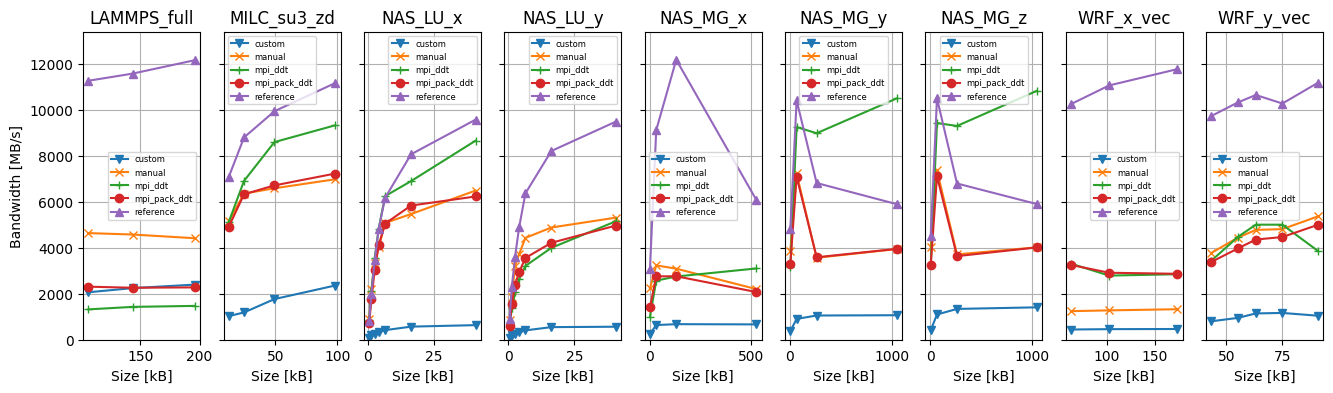

In [19]:
dfraw = load_bench_files('../../../results/ddtbench/one-node/ddtbench*.out')
dfall = compute_mean_std(dfraw)
plot_horizontal(dfall, filename="ddtbench-one-node.pdf")

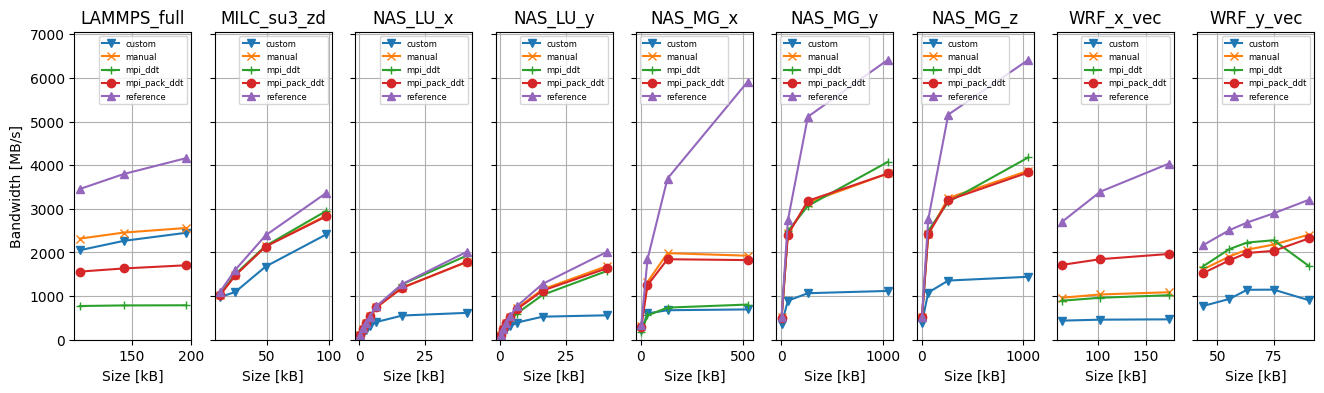

In [20]:
dfraw = load_bench_files('../../../results/ddtbench/two-node/ddtbench*.out')
dfall = compute_mean_std(dfraw)
plot_horizontal(dfall, filename="ddtbench-two-node.pdf")

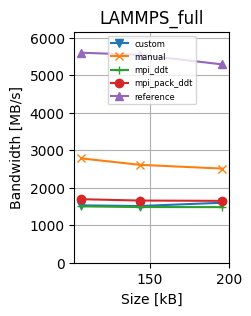

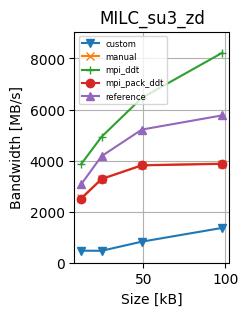

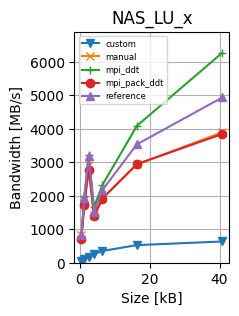

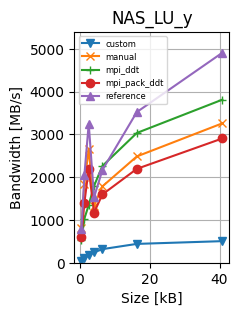

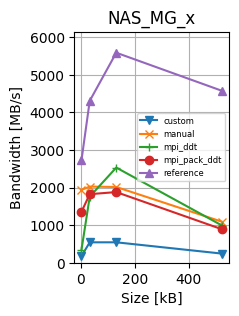

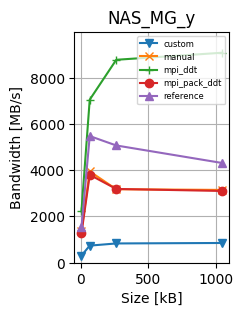

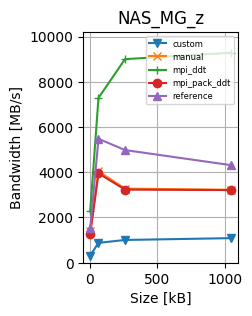

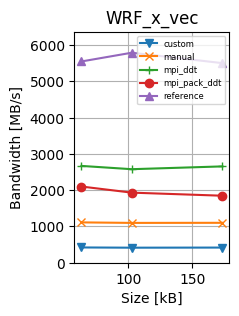

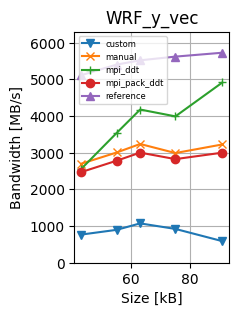

In [10]:

filename = "ddtbench.pdf"
pp = PdfPages(filename)
for bench in dfall.testname.unique():
    fig = plt.figure(figsize=(2, 3))
    ax=plt.subplot()

    df = dfall[ dfall.testname == bench ]
    maxy = 0
    for name, v in df.groupby(["method"]):
        method = name[0]
        xvals = v['bytes'] / 1E3
        yvals = xvals / 1E3 / (v['time_avg'] / 1E6)
        yerrs = xvals / 1E3 / (v['time_std'] / 1E6)

        #ax.errorbar(xvals, yvals, yerrs, label="%s"%(method))
        ax.plot(xvals, yvals, label="%s"%(method), marker=get_marker(method))
        maxy = np.max([np.max(yvals), maxy])

    #ax.set_title("Barrier skew (%s %s per node)"%(npn, "processes" if (npn > 1) else "process"))
    ax.set_xlabel("Size [kB]")
    ax.set_ylabel("Bandwidth [MB/s]")
    ax.set_title(bench)
    ax.legend(prop={'size': 6})
    ax.set_ylim(bottom=0, top=maxy*1.1)
    ax.grid()
    #ax.plot()
    #fig.tight_layout()
    pp.savefig(fig)
    #plt.close(fig)

pp.close()

In [13]:
npns = df.npn.unique()

for npn in npns:
    filename = "barrierskew_hawk_nohdr_%s.pdf"%(npn)
    pp = PdfPages(filename)
    ndf = df[ df.npn.eq(npn) ]
    ndf = ndf.sort_values(by='nprocs')
    procs = ndf['nprocs'].to_list()
    alldata = ndf['data'].to_list()
    #print(ndf['data'])
    #print(procs)
    # dict mapping nprocs to nrep skews
    d = {x:(np.array(y)*1E6) for (x, y) in zip(procs, alldata)}
    #print(d)
    #print(alldata)
    datadf = pd.DataFrame(data=d)
    #print(datadf)
    fig = plt.figure(figsize=(8, 4))
    ax=plt.subplot()
    #datadf.boxplot(ax=ax, rot=45)
    datadf.boxplot(ax=ax)
    #ax.set_title("Barrier skew (%s %s per node)"%(npn, "processes" if (npn > 1) else "process"))
    ax.set_xlabel("Number of Processes")
    ax.set_ylabel("Barrier Skew [us]")
    #ax.plot()
    #fig.tight_layout()
    pp.savefig(fig)
    plt.close(fig)
    pp.close()

AttributeError: 'DataFrame' object has no attribute 'npn'